In [46]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import StratifiedKFold
import itertools
import time as tm

In [21]:
def sq_hinge_func(X,Y,W):
    return (np.maximum(1-np.multiply(X.dot(W),Y),0))**2

In [6]:
sq_hinge_func(X,Y,W)

array([  0.  , 129.96,   0.  ,   0.  , 681.21])

In [22]:
X=np.array([[1,2,3,4],[3,4,5,6],[5,6,7,8],[7,8,9,9],[10,11,12,13]])
Y=np.array([1,-1,1,1,-1])
W=np.array([0.5,0.1,0.5,1])

# np.multiply(Y,Z)

In [23]:
def loss_func(X,Y,W,C=1):
#     print(W.shape,)
    loss = 0.5*W.dot(W)+ C*sum(sq_hinge_func(X,Y,W))
    return loss

In [24]:
def getStepLength( eta, t ):
    return eta/np.sqrt(t+1)

In [25]:
def sq_hinge_gradient(X,Y,W,pred):
    n = Y.shape[0]
    gradients = np.zeros((n,))
    margin = np.multiply(pred,Y)
    gradients[margin < 1] = -2*(1-margin[margin<1])
    
    return gradients

In [26]:
def SCD(X,Y,coord,pred,n,_iter,W,C=1,eta=0.01):
    
    sq_hinge_gr = sq_hinge_gradient(X,Y,W,pred)  
#     batch_size = X.shape[0]
#     print(coord)
    gradient = W[coord] + C*(X.T)[coord].dot(np.multiply(Y,sq_hinge_gr))

    pred -= W[coord]*X[:,coord]
    W[coord] = W[coord]- getStepLength(eta,_iter)*gradient
    pred += W[coord]*X[:,coord]
    return W,pred

In [27]:
data = np.loadtxt('../data')

In [28]:
labels = data[:,0]
features = data[:,1:]

In [29]:
num_training = data.shape[0]

In [30]:
features = np.hstack((np.ones((num_training,1)),features))

In [79]:
randperm = np.random.permutation( 21 )
randpermInner = -1
def getCyclicCoord( currentCoord,n ):
    if currentCoord >= n-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1
    
def getRandCoord( currentCoord,n ):
    return random.randint( 0, n-1 )

def getRandpermCoord( currentCoord,n ):
    global randperm, randpermInner
    if randpermInner >= n-1 or randpermInner < 0 or currentCoord < 0:
        randpermInner = 0
        randperm = np.random.permutation( n)
        return randperm[randpermInner]
    else:
        randpermInner = randpermInner + 1
        return randperm[randpermInner]

In [83]:
def training(X,Y,W,C=1,eta=0.01,n_iter=10):
    
    n = X.shape[0]
    m = X.shape[1]
#     print(n,m,W.shape)
    loss = np.zeros(n_iter*m)
    i=0
    w_prev = np.copy(W)
    w_prev[0] = 100
    prev= 0
#     print(w_prev,W,np.linalg.norm(w_prev-W))
    while i < n_iter and np.linalg.norm(w_prev-W)>10**(-5):
#         print("Yes")
        w_prev = np.copy(W)
        pred = X.dot(W)
        j = getCyclicCoord(prev,m)
        prev = j
        W,pred = SCD(X,Y,j,pred,n,i,W,C,eta)
#         print()
        loss[m*i+j] = loss_func(X,Y,W,C)
        
        i+=1;
#     if(i>=n_iter) :print(n_iter,"iterations completed")
    return W,loss
    

In [32]:
def predict(w,X):
    n = X.shape[0]
#     X = np.hstack((np.ones((n,1)),features))
    pred = np.ones(n)
    pred[X.dot(w) < 0] = -1 
    return pred

In [33]:
def KFold(n,split,shuffle=True):
    indices = [i for i in range(n)]
    random.shuffle(indices)
    split_index = [0,]
    for k in range(split-1):
        split_index.append(int(n*(k+1)/split))
    split_index.append(n)
#     print(split_index)
    folds=[]
    for tst in range(1,split+1):
        training_folds,test_folds=[],[]
        test_folds= indices[split_index[tst-1]:split_index[tst]]
        for tr in range(1,split+1):
            if(tr != tst):
                training_folds.extend(indices[split_index[tr-1]:split_index[tr]])
        folds.append([training_folds,test_folds])
        
    return folds

In [34]:
KFold(10,5)

[[[3, 9, 7, 5, 2, 8, 4, 1], [0, 6]],
 [[0, 6, 7, 5, 2, 8, 4, 1], [3, 9]],
 [[0, 6, 3, 9, 2, 8, 4, 1], [7, 5]],
 [[0, 6, 3, 9, 7, 5, 4, 1], [2, 8]],
 [[0, 6, 3, 9, 7, 5, 2, 8], [4, 1]]]

In [51]:
def cross_val(X,Y,C=1,eta=0.1,n_iter=10,split=1):
    print("CV for C=",C,"eta=",eta)
    split = split
    num_data = X.shape[0]
    m= X.shape[1]
    cv = KFold(num_data,split,shuffle=True)
    loss=np.zeros(n_iter*X.shape[1])
    i,mean = 0,0
    for tr_index, tst_index in cv:
        X_tr,Y_tr = X[tr_index],Y[tr_index]
        X_tst,Y_tst = X[tst_index],Y[tst_index]
        w = np.ones(X.shape[1])
        tic = tm.perf_counter()
        w,_loss = training(X_tr,Y_tr,w,C,eta,n_iter)
        toc = tm.perf_counter()
        loss += loss_func(X_tst,Y_tst,w)
        pred = predict(w,X_tst)
        mean += sum(pred == Y_tst)/(X_tst.shape[0])
        i+=1
        print('split: ',i,sum(pred == Y_tst)/(X_tst.shape[0]))
        
    plt.plot(range(n_iter*m),loss/split,label="C="+str(C))  
    print(loss[-1],toc-tic)
    print('Mean Accuracy: ',np.round(mean/split,3),"\n")
      

100 iterations completed
Accuracy:  0.902 



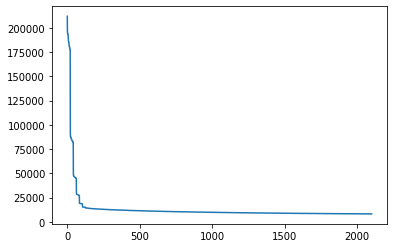

In [18]:
# C=[0.001,0.01,0.02]
# eta = [0.01,0.1,]
# batch_size = [32,128,512]
C = 1
eta=0.0001
batch_size =128
n_iter = 100
X,Y = features,labels
m = X.shape[1]
# legends= []
# cross_val(features,labels,C,eta,n_iter,2)
w = np.ones(X.shape[1])
w,loss = training(X,Y,w,C,eta,n_iter)
# loss += _loss
pred = predict(w,X)
score= sum(pred == Y)/(X.shape[0])
# print("score",score)
plt.plot(range(n_iter*m),loss,label="C="+str(C))  
print('Accuracy: ',np.round(score,3),"\n")

CV for C= 1 eta= 1e-05
split:  1 0.12475
split:  2 0.12375
split:  3 0.18875
split:  4 0.857
split:  5 0.1775
62652.8570018604 1.4618520889998763
Mean Accuracy:  0.294 

CV for C= 1 eta= 0.0001
split:  1 0.87825
split:  2 0.86925
split:  3 0.8905
split:  4 0.8975
split:  5 0.90175
16018.323067401554 47.5391512139995
Mean Accuracy:  0.887 

CV for C= 1 eta= 0.0005
split:  1 0.88075
split:  2 0.89975
split:  3 0.87875
split:  4 0.9015
split:  5 0.81825
19085.285166450056 2.782530600999962
Mean Accuracy:  0.876 

CV for C= 1 eta= 0.001
split:  1 0.8425
split:  2 0.901
split:  3 0.8725
split:  4 0.89575
split:  5 0.88075
17718.03249673888 3.212559102999876
Mean Accuracy:  0.879 



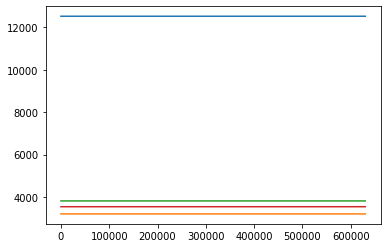

In [80]:
# C=[0.001,0.01,0.02]
eta = [0.00001,0.0001,0.0005,0.001]
# batch_size = [32,128,512,1024,2048]
param = list(itertools.product(eta,batch_size))
C = 1
# eta=0.0001
# batch_size =512
n_iter = 30000
legends= []
for i in eta:
    cross_val(features,labels,C,i,n_iter,5)
# w = np.ones(features.shape[1])
# w,loss = training(features,labels,w,C,eta,batch_size,n_iter)
# pred = predict(w,features)
# plt.plot(range(n_iter),loss,label="C="+str(C))  
# print('Mean Accuracy: ',np.round(sum(pred == labels)/(features.shape[0]),3),"\n")

CV for C= 1 eta= 1e-05
split:  1 0.131
split:  2 0.1095
split:  3 0.103
split:  4 0.139
split:  5 0.1005
108416.52607000024 0.5869818929995745
Mean Accuracy:  0.117 

CV for C= 1 eta= 0.0001
split:  1 0.8875
split:  2 0.88525
split:  3 0.50525
split:  4 0.888
split:  5 0.89975
15497.191687244012 3.211912315000518
Mean Accuracy:  0.813 

CV for C= 1 eta= 0.0005
split:  1 0.90075
split:  2 0.89775
split:  3 0.8805
split:  4 0.89375
split:  5 0.907
9309.558779549272 5.574438912000005
Mean Accuracy:  0.896 

CV for C= 1 eta= 0.001
split:  1 0.8455
split:  2 0.90625
split:  3 0.8555
split:  4 0.88875
split:  5 0.8925
14291.681919504495 11.184605289000501
Mean Accuracy:  0.878 



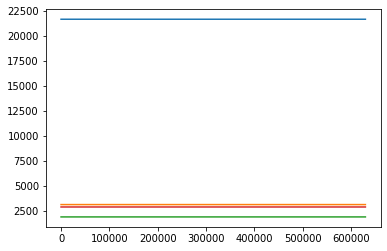

In [82]:
# C=[0.001,0.01,0.02]
eta = [0.00001,0.0001,0.0005,0.001]
# batch_size = [32,128,512,1024,2048]
param = list(itertools.product(eta,batch_size))
C = 1
# eta=0.0001
# batch_size =512
n_iter = 30000
legends= []
for i in eta:
    cross_val(features,labels,C,i,n_iter,5)
# w = np.ones(features.shape[1])
# w,loss = training(features,labels,w,C,eta,batch_size,n_iter)
# pred = predict(w,features)
# plt.plot(range(n_iter),loss,label="C="+str(C))  
# print('Mean Accuracy: ',np.round(sum(pred == labels)/(features.shape[0]),3),"\n")

CV for C= 1 eta= 1e-05
split:  1 0.14925
split:  2 0.8645
split:  3 0.105
split:  4 0.1205
split:  5 0.11925
86113.26542382347 0.6227525650001553
Mean Accuracy:  0.272 

CV for C= 1 eta= 0.0001
split:  1 0.90225
split:  2 0.905
split:  3 0.89525
split:  4 0.879
split:  5 0.90175
9902.723232169483 13.833154038999965
Mean Accuracy:  0.897 

CV for C= 1 eta= 0.0005
split:  1 0.8925
split:  2 0.86825
split:  3 0.8715
split:  4 0.8175
split:  5 0.8535
22502.302256277482 1.9696736839996447
Mean Accuracy:  0.861 

CV for C= 1 eta= 0.001
split:  1 0.83475
split:  2 0.82875
split:  3 0.759
split:  4 0.81875
split:  5 0.7505
45861.18706290419 0.8793586270003289
Mean Accuracy:  0.798 



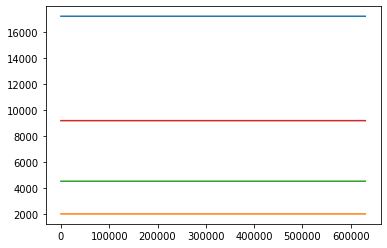

In [84]:
# C=[0.001,0.01,0.02]
eta = [0.00001,0.0001,0.0005,0.001]
# batch_size = [32,128,512,1024,2048]
param = list(itertools.product(eta,batch_size))
C = 1
# eta=0.0001
# batch_size =512
n_iter = 30000
legends= []
for i in eta:
    cross_val(features,labels,C,i,n_iter,5)
# w = np.ones(features.shape[1])
# w,loss = training(features,labels,w,C,eta,batch_size,n_iter)
# pred = predict(w,features)
# plt.plot(range(n_iter),loss,label="C="+str(C))  
# print('Mean Accuracy: ',np.round(sum(pred == labels)/(features.shape[0]),3),"\n")